In [1]:
import numpy as np
import gizmo_analysis as gizmo
import utilities as ut
from matplotlib import pyplot as plt
import astropy
from IPython.display import clear_output
import matplotlib.ticker as ticker


from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from astropy.io import ascii

from scipy import optimize, stats
import emcee
import corner

plt.rcParams["font.family"] = "Serif"
plt.rcParams.update({'font.size': 13, 'font.weight' : 100})

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import imageio

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [22]:
# Dictionary with galaxy name and corresponding local directory containing the HDF5, snapshot_times.txt, etc.
# - for ease of access. 

dirs = { 'm11b_hires' : 'D:\Data\m11b_res260' , 'm11q' : 'D:\Data\m11q_res880', 
       'm11h' : 'D:\Data\m11h_res880', 'm10v' : 'D:\Data\m10v_res250',
       'm11d' : 'D:\Data\m11d_res7100', 'm12i' : 'D:\Data\m12i_res7100',
       'm12i_low_res' : 'D:\Data\m12i_res57000', 'm11e' : 'D:\Data\m11e_res7100',
       'm11i' : 'D:\Data\m11i_res7100', 'm10q' : 'D:\Data\m10q_res250',
       'm09' : 'D:\Data\m09_res30', 'm11b_cr' : 'D:\Data\m11b_res2100_v2', 'm11b' : 'D:\Data\m11bfin'}

# Function below loads the snapshot 600 from the directory that it has been assigned to. Simply use the galaxy's name
# in lowercase to get your data (provided that the directory is properly set)

def load():
    galaxy = 'm11i'
    
    print('LOADING GALAXY: ' + galaxy + " in " + dirs[galaxy])
    
    part = gizmo.io.Read.read_snapshots(['star'], 'redshift', 0, simulation_directory=dirs[galaxy],
                                       assign_formation_coordinates = True, assign_hosts='mass', 
                                        assign_hosts_rotation=True)
    return part, galaxy

part, galaxy = load()


species='star'
mass = part[species].prop('mass')
age = part[species].prop('age')
feh  = part[species].prop('metallicity.fe')
sife = part[species].prop('metallicity.si - metallicity.fe')
cafe = part[species].prop('metallicity.ca - metallicity.fe') 
ofe = part[species].prop('metallicity.o - metallicity.fe') 
form = part[species].prop('host.distance.principal.spherical')
ids = part[species].prop('id')

#Rxy = part[species].prop('host.distance.principal.cylindrical')[:,0]
#z = part[species].prop('host.distance.principal.cylindrical')[:,1]
mgfe = part[species].prop('metallicity.mg - metallicity.fe')

x = part[species].prop('host.distance.principal')[:,0]
y = part[species].prop('host.distance.principal')[:,1]
z = part[species].prop('host.distance.principal')[:,2]

R = part[species].prop('host.distance.principal.spherical')[:,0]
phi = part[species].prop('host.distance.principal.cylindrical')[:,2]*(180.0/np.pi)
Rform = form[:,0]

time_cons = 13.73621602   

LOADING GALAXY: m11i in D:\Data\m11i_res7100

# in utilities.simulation.Snapshot():
* reading:  D:\Data\m11i_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  D:\Data\m11i_res7100/output\snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 4592104 particles
    dark2     (id = 2): 3248534 particles
    gas       (id = 0): 4397417 particles
    star      (id = 4): 194680 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    D:\Data\m11i_res7100/output\snapshot_600.hdf5

! cannot find MUSIC config file:  D:\Data\m11i_res7100/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA box):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties
! warning: star mass [min, med, max] = [3802.071, 5253.02

(0.0, 3.0, 0.0, 50.0)

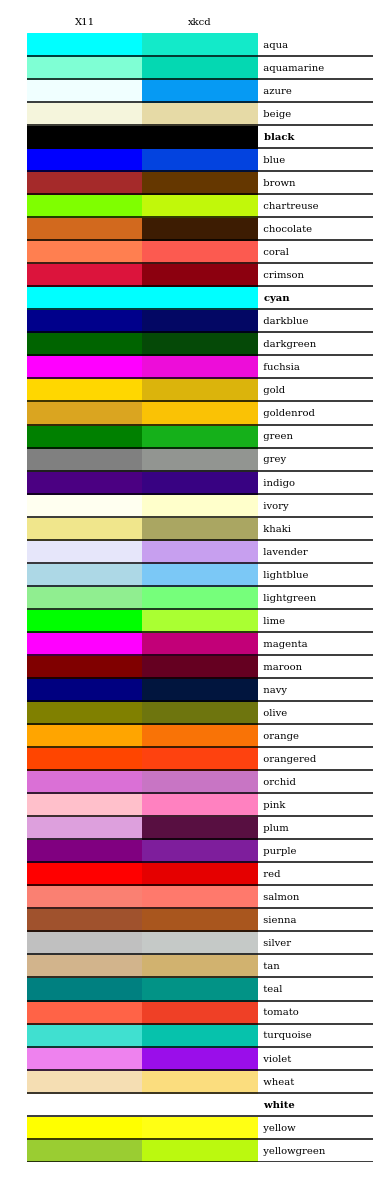

In [3]:
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch

overlap = {name for name in mcd.CSS4_COLORS
           if "xkcd:" + name in mcd.XKCD_COLORS}

fig = plt.figure(figsize=[4.8, 16])
ax = fig.add_axes([0, 0, 1, 1])

for j, n in enumerate(sorted(overlap, reverse=True)):
    weight = None
    cn = mcd.CSS4_COLORS[n]
    xkcd = mcd.XKCD_COLORS["xkcd:" + n].upper()
    if cn == xkcd:
        weight = 'bold'

    r1 = mpatch.Rectangle((0, j), 1, 1, color=cn)
    r2 = mpatch.Rectangle((1, j), 1, 1, color=xkcd)
    txt = ax.text(2, j+.5, '  ' + n, va='center', fontsize=10,
                  weight=weight)
    ax.add_patch(r1)
    ax.add_patch(r2)
    ax.axhline(j, color='k')

ax.text(.5, j + 1.5, 'X11', ha='center', va='center')
ax.text(1.5, j + 1.5, 'xkcd', ha='center', va='center')
ax.set_xlim(0, 3)
ax.set_ylim(0, j + 2)
ax.axis('off')

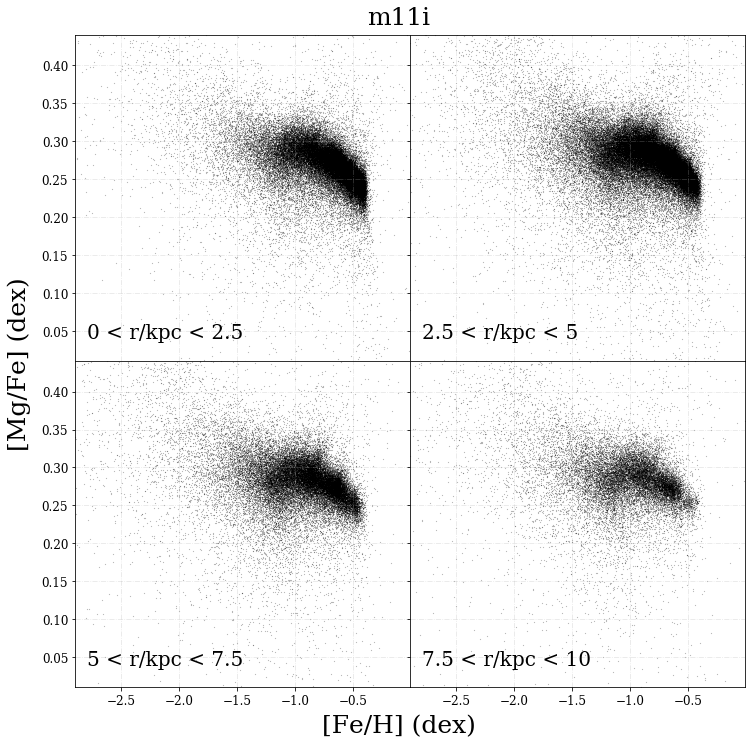

In [4]:
fig, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True,
                                                                         figsize = (12,12))

axes = [ax1,ax2,ax3,ax4]
rngs = [0,2.5,5,7.5,10]



for i in range(0,4):
    ind = np.where( (R > rngs[i]) & (R < rngs[i + 1]) )
    axes[i].grid(ls = '-.', alpha = 0.3)
    axes[i].scatter(feh[ind], mgfe[ind], c = 'black', s = 0.01)
    axes[i].set_xlim(-2.9, -0.01)
    axes[i].set_ylim(0.01,0.44)
    axes[i].text(-2.8, .04, str(rngs[i]) + " < r/kpc < " + str(rngs[i+1]), size = 20)
    xticksbot = axes[i].xaxis.get_majorticklabels()
    yticksbot = axes[i].yaxis.get_majorticklabels()
    plt.setp(xticksbot, size = 12)
    plt.setp(yticksbot, size = 12)
    if(i == 3):
        plt.setp(xticksbot[0], visible = False) 
    if(i == 0):
        plt.setp(yticksbot[0], visible = False)    
    
fig.text(0.5, 0.9, "m11i", size = 25, va = 'center', ha = 'center')
fig.text(0.5,0.08,"[Fe/H] (dex)", size = 25, va = 'center', ha = 'center')
fig.text(0.06,0.5,"[Mg/Fe] (dex)", size = 25, va = 'center', ha = 'center', rotation = 90)

plt.subplots_adjust(hspace = 0, wspace = 0)

plt.savefig("m11i_left.png", dpi = 72, bbox_inches = 'tight')

-0.9054392
0.2717877


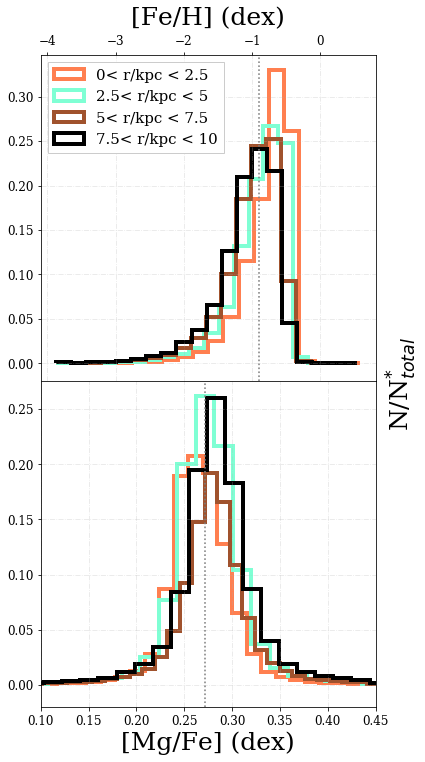

In [5]:
fig, ( (ax1), (ax2) ) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False,
                                                                         figsize = (6,12))

axes = [ax1,ax2]
rngs = [0,2.5,5,7.5,10]
colors = ['coral', 'aquamarine', 'sienna', 'black']
lss = ['-', '-', '-', '-']
weights1 = []
weights2 = []
l = 4

for j in range(0,2):
    axes[j].grid(ls = '-.', alpha = 0.3)

    for i in range(0,4):
        
        ind = np.where( (R > rngs[i]) & (R < rngs[i + 1]) )
        

        if(j == 0):
            weights1 = np.ones_like(feh[ind])/float(len(feh[ind]))
            axes[j].hist(feh[ind], color = colors[i], lw = l, histtype = 'step', weights = weights1, bins = 20,
                        label = str(rngs[i]) + "< r/kpc < " + str(rngs[i+1]), ls = lss[i])
            axes[j].xaxis.tick_top()
            axes[j].set_title("[Fe/H] (dex)", size = 25, pad = 30)
            axes[j].legend(fontsize = 15, loc = 2, framealpha = 1, fancybox = False)
            axes[j].axvline(np.average(feh[np.where(R < 10)]), alpha = 0.4, color = 'gray', ls = ':')
        if(j == 1):
            weights2 = np.ones_like(mgfe[ind])/float(len(mgfe[ind]))
            axes[j].hist(mgfe[ind], color = colors[i],lw = l, histtype = 'step', weights = weights2, bins = 90,
                        ls = lss[i])
            axes[j].set_xlim(0.1, 0.45)
            axes[j].set_xlabel("[Mg/Fe] (dex)", size = 25)
            axes[j].axvline(np.average(mgfe[np.where(R < 10)]), alpha = 0.4, color = 'gray', ls = ':')
        xticksbot = axes[j].xaxis.get_majorticklabels()
        yticksbot = axes[j].yaxis.get_majorticklabels()
        plt.setp(xticksbot, size = 12)
        plt.setp(yticksbot, size = 12)
    axes[j].set_ylim(-0.02)

print(np.average(feh[np.where(R < 10)]))
print(np.average(mgfe[np.where(R < 10)]))
    
fig.text(0.96,0.5,"N/N$^{*}_{total}$", size = 25, va = 'center', ha = 'center', rotation = 90)
plt.subplots_adjust(hspace = 0, wspace = 0)

plt.savefig("m11i_right.png", dpi = 72, bbox_inches = 'tight')

13.735961468139648


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


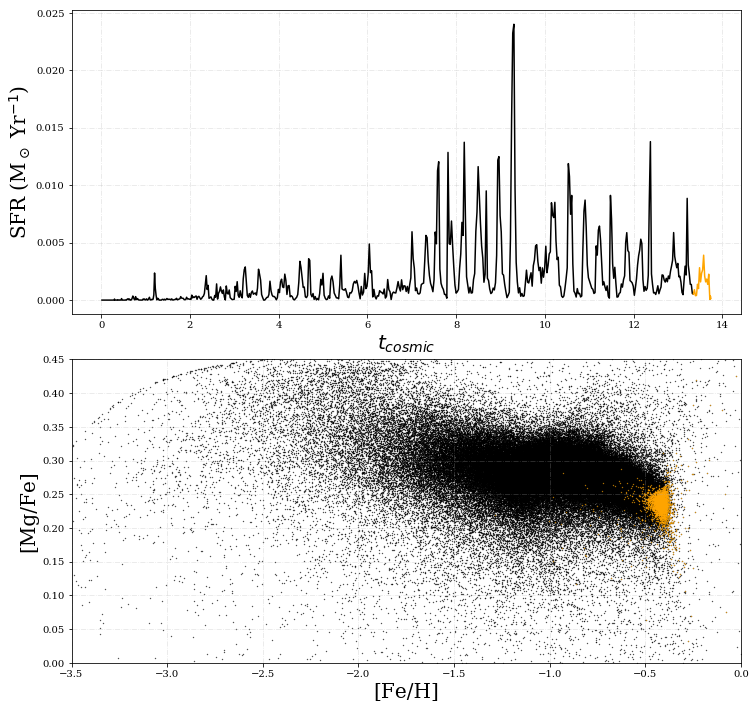

In [74]:
fig, ( (ax1), (ax2) ) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False,
                                                                         figsize = (12,12))
snapno, sf, redshift, time, time_width = np.loadtxt(dirs['m11i'] + "\snapshot_times.txt", unpack = True)

ct = time_cons - age
print(np.max(ct))

ind = [np.where(ct > time[580])]


colors = ['coral', 'aquamarine', 'sienna', 'black']
lss = ['-', '-', '-', '-']
weights1 = []
weights2 = []
l = 4
inbin = []
for i in range(1, len(snapno)):
    inbin.append(np.sum(mass[np.where((ct > time[i-1]) & (ct < time[i]))]))



ax1.grid(ls = '-.', alpha = 0.3)
ax2.grid(ls = '-.', alpha = 0.3)

ax1.plot(time[0:575], np.array(inbin[0:575])/(1000000000), c = 'black')
ax1.plot(time[574:600], np.array(inbin[574:600])/(1000000000), c = 'orange')
ax1.set_ylabel(r"SFR (M$_\odot$ Yr$^{-1}$)", size = 20)
ax1.set_xlabel(r"$t_{cosmic}$", size = 20)


ax2.scatter(feh,mgfe, s = 0.1, c = 'black')
ax2.scatter(feh[ind],mgfe[ind], s = 0.1, c = 'orange')
ax2.set_xlim(-3.5,0)
ax2.set_ylim(-0., 0.45)
ax2.set_ylabel("[Mg/Fe]", size = 20)
ax2.set_xlabel("[Fe/H]", size = 20)


plt.subplots_adjust(hspace = 0.15, wspace = 0)

plt.savefig("m11i_finalburst.png", dpi = 72, bbox_inches = 'tight')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.


(-0.0, 0.45)

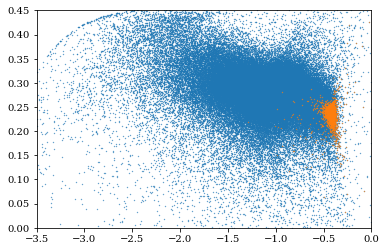

7.679185859852649
2.081398370634382
[11.717341629365619, 9.233395781151456, 8.964861094858033, 7.152251962377428, 3.1913653395494395, 2.5871622953892377, 1.982959251229036, 1.44588987864219]


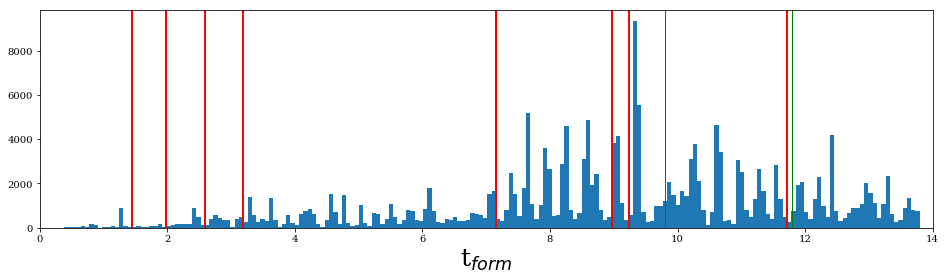

In [6]:
plt.figure(figsize=(16,4))
plot = plt.hist(13.79874-age, bins = 200)
plt.xlabel(r"t$_{form}$", size = 25)
plt.xlim(0,14)

theones = plot[0].sort

needed = [31, 68, 72, 99, 158, 167, 176, 184]

for i in range(0, len(needed)):
    needed[i] = 200 - needed[i]

values = []
print(age[132])
for i in range(130, len(plot[0]) - 1):
    if(plot[0][i-1] <= plot[0][i] and plot[0][i] >= plot[0][i+1]):
        values.append(i)
        #plt.axvline(plot[1][i], color = 'r')
        
#needed.reverse()

ages = []
for i in needed:
    plt.axvline(plot[1][i], color ='red', lw = 2)
    ages.append(plot[1][i])

plt.axvline(13.79874-2, c = 'g', lw = 1)
plt.axvline(13.79874-4, c = 'g', lw = 1)
print(str(13.79874-plot[1][169]))



print(ages)
plt.savefig("m11b_peaks2.png", dpi = 150, bbox_inches = 'tight')
plt.show()

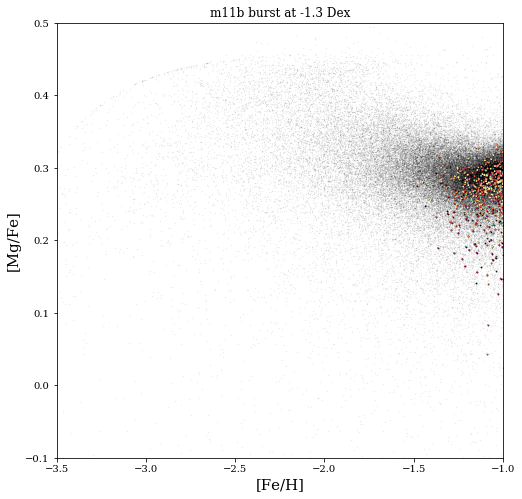

In [7]:
ind = np.where((age < 4) & (age > 1))
ind2 = np.where((age < 4) & (age > 2))

plt.figure(figsize = (8,8))
plt.scatter(feh[np.where(age > 4)], mgfe[np.where(age > 4)], c = 'black', s = 0.1, alpha = 0.1)
plt.scatter(feh[ind], mgfe[ind], c = 'black', s = 0.6)
plt.scatter(feh[ind2], mgfe[ind2], c = 13.79874-age[ind2], cmap = 'Spectral', s = 0.6)
plt.xlim(-3.5, -1)
plt.ylim(-0.1, 0.5)
plt.xlabel("[Fe/H]", size = 15)
plt.ylabel("[Mg/Fe]", size = 15)
plt.title("m11b burst at -1.3 Dex")
plt.savefig("m11b_b2.png", dpi = 150, bbox_inches = 'tight')
plt.show()

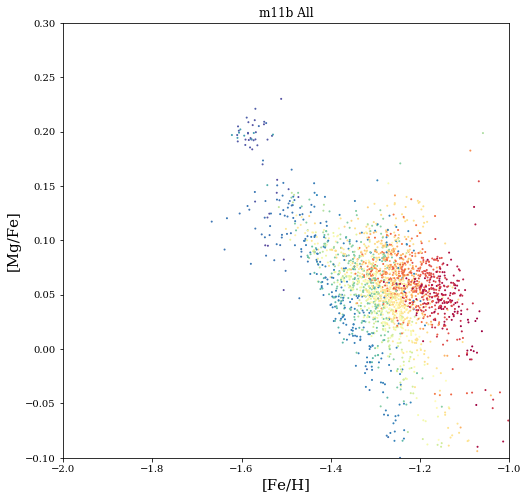

In [7]:
ind = np.where((age < 4) & (age > 1))
plt.figure(figsize = (8,8))
plt.scatter(feh[ind], mgfe[ind], c = age[ind], cmap = 'Spectral', s = 1)
plt.xlim(-2, -1)
plt.ylim(-0.1, 0.3)
plt.xlabel("[Fe/H]", size = 15)
plt.ylabel("[Mg/Fe]", size = 15)
plt.title("m11b All")
plt.savefig("m11b_chevron.png", dpi = 150, bbox_inches = 'tight')
plt.show()

11.65079387283024
9.110918946401194
8.819523815197758
7.079724559885801
2.9993755582948816
2.417347623656593
1.741780240941498
1.2269730486369395


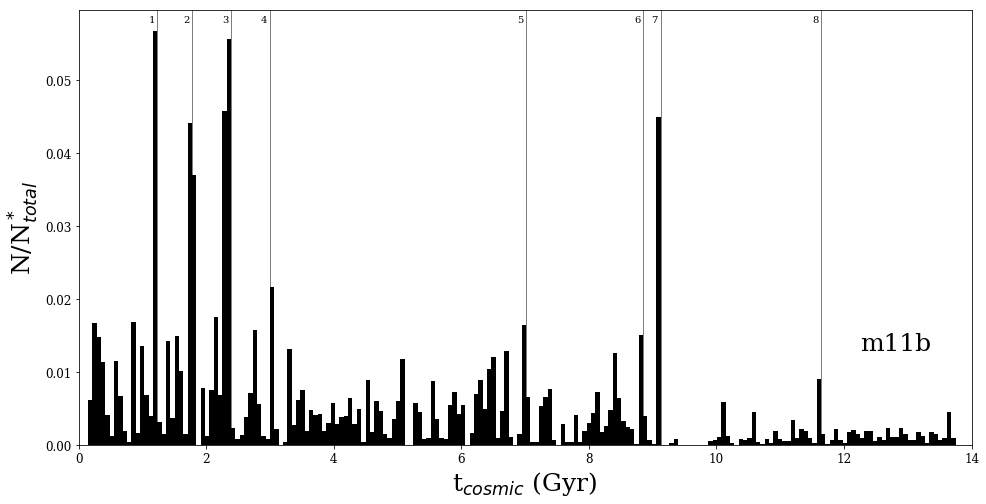

In [8]:
width = 0.05
weights = np.ones_like(13.798-age)/float(len(13.798-age))

plt.figure(figsize=(16,8))
plt.xlabel(r"t$_{cosmic}$ (Gyr)", size = 25)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.ylabel(r"N/N$^*_{total}$", size = 25)
plt.text(12.25, .013, "m11b", size = 25)
plot = plt.hist(13.79874 - age, bins = 200, weights = weights, color = 'black')
plt.xlim(0,14)

agers = [] # need to initialize this as ages is appended in a later loop

#theones = plot[0].sort
count = 2

for i in needed:
    plt.axvline(plot[1][i], color ='black', lw = 0.5)
    plt.text(plot[1][i] - .14, .058, str(10-count), size = 10, rotation = 0)
    agers.append(plot[1][i])
    count += 1
    print(np.average(age[np.where( (age < plot[1][i] + 0.1) & (age > plot[1][i] - 0.1))]))
    
#plt.savefig('m11b_rr_top.pdf', bbox_inches = 'tight')
plt.savefig('m11b_rr_top.png', bbox_inches = 'tight')

In [9]:
print(agers)

[11.639139654309126, 9.122106758230425, 8.849995093789484, 7.0132413588131355, 2.9995943083092618, 2.3873430633171453, 1.775091818325029, 1.2308684894431479]


In [10]:
ages = agers[::-1] 
for i in range(0, len(ages)):
    print(ages[i])
    ages[i] = ages[i]
print(ages)
ua = 13.79874

1.2308684894431479
1.775091818325029
2.3873430633171453
2.9995943083092618
7.0132413588131355
8.849995093789484
9.122106758230425
11.639139654309126
[1.2308684894431479, 1.775091818325029, 2.3873430633171453, 2.9995943083092618, 7.0132413588131355, 8.849995093789484, 9.122106758230425, 11.639139654309126]


In [20]:
ages = np.array(ages)
print(13.7989 - ages)
print(ages[0])
ages[0] = ua - ages[0] 
ages[1] = ua - ages[1] 
ages[2] = ua - ages[2] + 0.005
ages[3] = ua - ages[3] - 0.005
ages[4] = ua - ages[4] # WIDTH DECREASE ONLY - 0.02
ages[5] = ua - ages[5] # Make width like 0.02
ages[6] = ua - ages[6] - 0.022 # UNCHANGED 
ages[7] = ua - ages[7] # WIDTH to 0.02
#ages[8] = ua - 11.8 # WIDTH TO 0.02

print(ages)

[ 1.23102849  1.77525182  2.38750306  3.00475431  7.01340136  8.85015509
  9.14426676 11.63929965]
12.567871510556852
[ 1.23086849  1.77509182  2.39234306  2.99959431  7.01324136  8.84999509
  9.12210676 11.63913965]


[ 1.23086849  1.77509182  2.39234306  2.99959431  7.01324136  8.84999509
  9.12210676 11.63913965]
tform7 = 11.639139654309126
tform6 = 9.122106758230425
tform4 = 7.0132413588131355
tform3 = 2.9995943083092618
tform2 = 2.3923430633171447


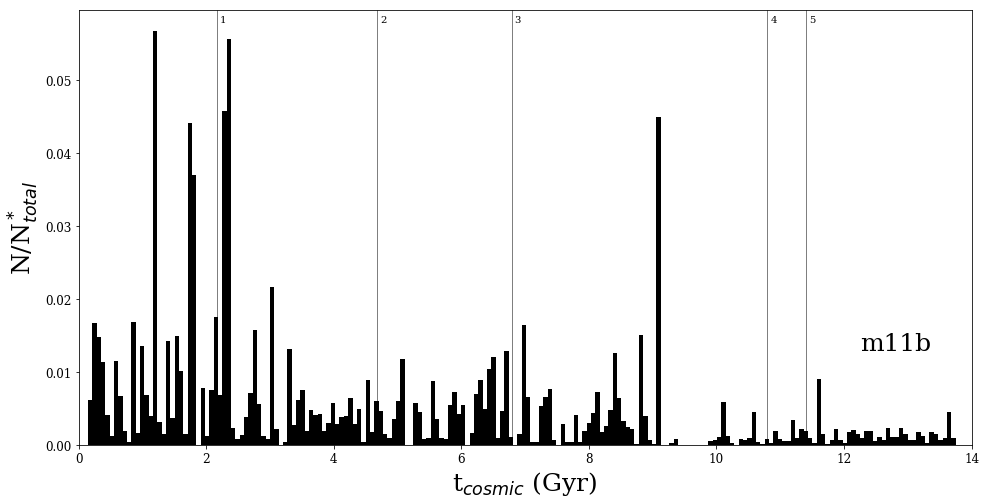

In [21]:
width = 0.05
weights = np.ones_like(13.798-age)/float(len(13.798-age))
desired = [2,3,4,6,7] # Desired INDEX of the AGES LIST that we've selected for our peaks above

plt.figure(figsize=(16,8))
plt.xlabel(r"t$_{cosmic}$ (Gyr)", size = 25)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.ylabel(r"N/N$^*_{total}$", size = 25)
plt.text(12.25, .013, "m11b", size = 25)
plot = plt.hist(13.798974 - age, bins = 200, weights = weights, color = 'black')
plt.xlim(0,14)

count = 1
print(ages)
for i in desired[::-1]:
    print("tform" + str(i) +" = " + str(ages[i]))
    #plt.axvline(ages[i]-0.1, color ='black', lw = 0.5)
    plt.text(13.79897 - ages[i] + 0.05, .058, str(count), size = 10, rotation = 0)
    count += 1

    plt.axvline(13.79897 - ages[i], color ='black', lw = 0.5)


#plt.savefig('m11bv2_6_top.pdf', bbox_inches = 'tight')
plt.savefig('m11bv2_6_top.png', bbox_inches = 'tight')

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


[0, 2, 3, 4, 6, 7]
i: 1
ilist[i]: 2
AGE: 1.7750918183250288
AGE - w: 1.6750918183250287
AGE + w: 1.875091818325029
Tform : [1.68,1.88]
--------------------------------
i: 2
ilist[i]: 3
AGE: 2.3923430633171447
AGE - w: 2.2923430633171447
AGE + w: 2.492343063317145
Tform : [2.29,2.49]
--------------------------------
i: 3
ilist[i]: 4
AGE: 2.9995943083092618
AGE - w: 2.8995943083092617
AGE + w: 3.099594308309262
Tform : [2.9,3.1]
--------------------------------
i: 4
ilist[i]: 6
AGE: 7.0132413588131355
AGE - w: 6.913241358813136
AGE + w: 7.113241358813135
Tform : [6.91,7.11]
--------------------------------
i: 5
ilist[i]: 7
AGE: 8.849995093789484
AGE - w: 8.749995093789485
AGE + w: 8.949995093789484
Tform : [8.75,8.95]
--------------------------------


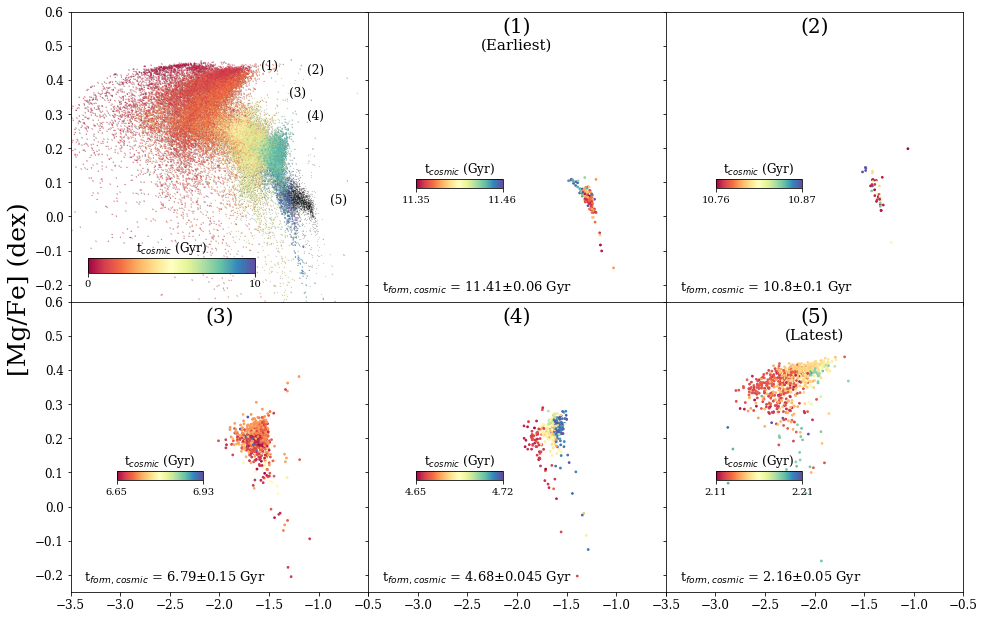

In [22]:
indices = []
indices2 = []
rfinds = []
rfinds2 = []
width = 0.1
countsarr = []
xbinsarr = []
ybinsarr = []
imagearr = []
widths = [0.1,0.15,0.06,0.1,0.15,0.05,0.045,0.05,0.1]



cmap1 = 'Spectral'

# For regions with significant Rform

ln = [0.29,0.55,0.81]
lefts = [ln[0],ln[1]-.125,ln[2]-.125,ln[0]-.125,ln[1]-.125,ln[2]-.125,ln[0]-.125,ln[1]-.125,ln[2]-0.125]
        #   1       2           3         4          5          6          7            8         9
lefts = np.array(lefts)

bottoms = [.7,.7,.7,.32,.32,.32,.15,.15,.15]

irange = 8

for i in range(0,irange):
    bottoms[i] = bottoms[i] - .1 #Adjust bottoms

xarray = np.linspace(-5,0)

for i in range(0,irange):
    indices.append(np.where( (age >= ages[i]-widths[i]) & (age <= ages[i] + widths[i]) ))
                            #& (Rform < 100)))
    
    indices2.append(np.where( (age >= ages[i]-widths[i]) & (age <= ages[i] + widths[i]) ))
                             #& (Rform < 20)))
    
    # Temporary assignment
    
    countsarrt,xbinsarrt,ybinsarrt,imagearrt = plt.hist2d(feh[indices[i]], mgfe[indices[i]], bins = [100,100])
    plt.close()
    
    # Assigning to the indices
    countsarr.append(countsarrt)
    xbinsarr.append(xbinsarrt)
    ybinsarr.append(ybinsarrt)
    imagearr.append(imagearrt)
    
    rfinds.append(np.where( (age >= ages[i]-width) 
                           & (age <= ages[i] + width ) 
                           & (Rform >= 50) & (Rform < 100)))
    
    rfinds2.append(np.where( (age >= ages[i]-width) 
                            & (age <= ages[i] + width ) 
                            & (Rform < 90)))
    
fig, ( (ax1, ax2, ax3), (ax4, ax5, ax6) ) = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True,
                                                                         figsize = (16,10.67))

axes = [ax1,ax2,ax3,ax4,ax5,ax6]

####################################################### PLOT ONE #########################################################
##########################################################################################################################

############# THE FOLLOWING CODE IS FOR GENERATING AN INSET COLORBAR ############

ind = np.where((age >= 13.798-11) )#& (Rform < 100))
counts1,xbins1,ybins1,image1 = plt.hist2d(feh[ind], mgfe[ind], bins = [100,100])

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(feh[ind], mgfe[ind], 
                                                                    age[ind], 'mean', bins= [100,100])

#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im = axes[0].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'Spectral', aspect='auto', vmin=0, vmax=10)
axes[0].clear()

cbar_ax = fig.add_axes([ 0.14, 0.54, 0.145, 0.02]) #left, bottom, width, height  # vertically oriented colorbar

cb = fig.colorbar(im, cax=cbar_ax, ticks = [0,10],  orientation = 'horizontal')
#cb.ax.yaxis.set_ticks_position("right")
cb.ax.set_xticklabels(['0', '10'], fontweight = 15) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"t$_{cosmic}$ (Gyr)")
#cb.ax.yaxis.set_label_position("left")

############# THE ABOVE CODE IS FOR GENERATING AN INSET COLORBAR ############

#ax1.scatter(feh,mgfe-0.0005, s = 0.5, alpha = 0.1, c = 'black')
axes[0].scatter(feh,mgfe, s = 0.02, color = 'black', alpha = 0.5)
axes[0].scatter(feh[ind],mgfe[ind], s = 0.05, c = 13.79897-age[ind], cmap = "Spectral")
#ax1.axvline(-2, ls = "--", color = 'black', lw = 0.8, alpha = 0.7)
#ax1.axhline(0.25, ls = "--", color = 'black', lw = 0.8, alpha = 0.7)

#axes[0].set_ylabel("[Mg/Fe]", size = 25)
#axes[0].set_xlabel("[Fe/H]", size = 25)
#axes[0].xaxis.set_label_position("top")
#axes[0].xaxis.tick_top()
axes[0].set_xlim(-3.5,-0.5)
axes[0].set_ylim(-0.25,0.6)
#axes[0].text(-2., 0.54,r'Global $\alpha$-abundance', ha = 'center', size = 20)
#axes[0].text(-2, 0.49,'([Fe/H] vs. [Mg/Fe])', ha = 'center', size = 15)

xticks = axes[0].xaxis.get_majorticklabels()
yticks = axes[0].yaxis.get_majorticklabels()
plt.setp(yticks[0], visible = False)
plt.setp(yticks, size = 12)

##########################################################################################################################
ilist = desired
if(len(ilist) < 6):
    ilist.insert(0,0)

print(ilist)

for i in range(1,6):
   
    print("i: " + str(i))
    print("ilist[i]: " + str(ilist[i]))
    print("AGE: " + str(ages[i]))
    print("AGE - w: " + str(ages[i] - width))
    print("AGE + w: " + str(ages[i] + width))
    print("Tform : [" + str(round(ages[i] - width,2)) + "," + str(round(ages[i] + width,2)) + "]")
    print("--------------------------------")
    
    bottomt = 13.798974-np.min(age[indices[ilist[i]]]) # Not 'ages' because this is the full list of ages - 
    topt = 13.798974-np.max(age[indices[ilist[i]]]) # - we select here the oldest and youngest stars in the galaxy.
    
    if(i > 0):
        ############# THE FOLLOWING CODE IS FOR GENERATING AN INSET COLORBAR ############
        
        #mean age for bins of stars in mgfe vs feh space
        mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(feh[indices[ilist[i]]], mgfe[indices[ilist[i]]], 
                                                                            13.7989-age[indices[ilist[i]]],
                                                                            'mean', bins= [100,100])
        
        #masks below cuts out where there are fewer stars than a particular threshold
        m1 = np.ma.masked_where(countsarr[i] < 1,  mean_age1)
        im1 = axes[i].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                        extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = cmap1, aspect='auto', vmin=bottomt,
                            vmax=topt)
        axes[i].clear()
        
        cbar_ax1 = fig.add_axes([lefts[i], bottoms[i]+0.05, 0.075, 0.0125]) #left, bottom, width, height  # vertically oriented colorbar
        
        cb1 = fig.colorbar(im1, cax=cbar_ax1, ticks = [bottomt, topt], orientation = 'horizontal')
        #cb.ax.yaxis.set_ticks_position("right")
        cb1.ax.set_xticklabels([str(round(bottomt,2)),str(round(topt,2))],
                              size = 10) # Used to make custom labels on the tick marks themselves
        cb1.ax.set_title(r"t$_{cosmic}$ (Gyr)", size = 12)
        #cb.ax.yaxis.set_label_position("left")
        
        ############# THE ABOVE CODE IS FOR GENERATING AN INSET COLORBAR ############
        
        # Main hist2d of global track
        #axes[i].hist2d(feh[indices[i]], mgfe[indices[i]], bins = 200, range = [[-3.5,-0.5],[-0.25,.6]], cmap = 'Greys')
        
        axes[i].scatter(feh[indices[ilist[i]]], mgfe[indices[ilist[i]]], s = 3, c = 13.798-age[indices[ilist[i]]],
                        cmap = cmap1)
    
        # Labels for Tform and panel number
        axes[i].text(-3.36, -0.22, 
                     r"t$_{form,cosmic}$ = " + str(round(13.798974 - ages[ilist[i]],2)) + r'$\pm$' + str(widths[ilist[i]]) + ' Gyr', size = 13)
        axes[i].text(-2., 0.54,'(' + str(i) + ')', ha = 'center', size = 20)
    
        if(i == 5):
            axes[i].text(-2, 0.49,'(Latest)', ha = 'center', size = 15)
        if(i == 1):
            axes[i].text(-2, 0.49,'(Earliest)', ha = 'center', size = 15)

    
        
        # INSET FOR RFORM
        #cbar_ax = fig.add_axes([lefts[i], bottoms[i], 0.075, 0.025]) #left, bottom, width, height  # vertically oriented colorbar
        #
        #if((i != 2)):
        #    cbar_ax.hist(Rform[indices2[ilist[i]]], color = 'black', bins = 11)
        #else:
        #    cbar_ax.hist(Rform[indices[ilist[i]]], color = 'black', bins = 11)

        #if(i == 2):
        #    cbar_ax.hist(Rform[rfinds[ilist[i]]] - 0.5, color = 'orange', bins = 1)
        #    cbar_ax.hist(Rform[rfinds[ilist[i]]] - 0.5, color = 'red', alpha = 0.4, bins = 1) # second for color

        #
        #cbar_ax.set_xlabel(r"r$_{form}$ (kpc)", size = 15)
        #cbar_ax.set_ylabel("N*")
        #
        ##cb.ax.yaxis.set_ticks_position("right")
        ##cb.ax.set_title(r"R$_{form}$ (kpc)")
        #cbar_ax.yaxis.set_label_position("right")
        
        #END INSET
        
        if(i < 3):
            xticksbot = axes[i].xaxis.get_majorticklabels()
            plt.setp(xticksbot, visible = False) 
        if(i > 2):
            xticksbot = axes[i].xaxis.get_majorticklabels()
            plt.setp(xticksbot, size = 12)
            if(i == 4):
                plt.setp(xticksbot[0], visible = False) 
                plt.setp(xticksbot[6], visible = False) 
            yticksbot = axes[i].yaxis.get_majorticklabels()
            plt.setp(yticksbot, size = 12)
        
        
        # Adjustments
        axes[i].set_xlim(-3.5,-0.5)
        axes[i].set_ylim(-0.25,0.6)

fig.text(0.29, 0.805, "(1)", size = 12)
fig.text(0.33, 0.8, "(2)", size = 12)
fig.text(0.315, 0.77, "(3)", size = 12)
fig.text(0.33, 0.74, "(4)", size = 12)
fig.text(0.35, 0.63, "(5)", size = 12)
        
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.07,0.52,"[Mg/Fe] (dex)", va = 'center', size = 25, rotation = 90)
#fig.text(0.51,0.064, "[Fe/H] (dex)", ha = 'center', size = 25)
plt.savefig('m11b_rr_6panel.png', bbox_inches = 'tight', dpi = 150)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


[0, 0, 0, 2, 4, 6]
i: 3
ilist[i]: 2
AGE: 2.9995943083092618
AGE - w: 2.8995943083092617
AGE + w: 3.099594308309262
Tform : [2.9,3.1]
--------------------------------
i: 4
ilist[i]: 4
AGE: 7.0132413588131355
AGE - w: 6.913241358813136
AGE + w: 7.113241358813135
Tform : [6.91,7.11]
--------------------------------
i: 5
ilist[i]: 6
AGE: 8.849995093789484
AGE - w: 8.749995093789485
AGE + w: 8.949995093789484
Tform : [8.75,8.95]
--------------------------------


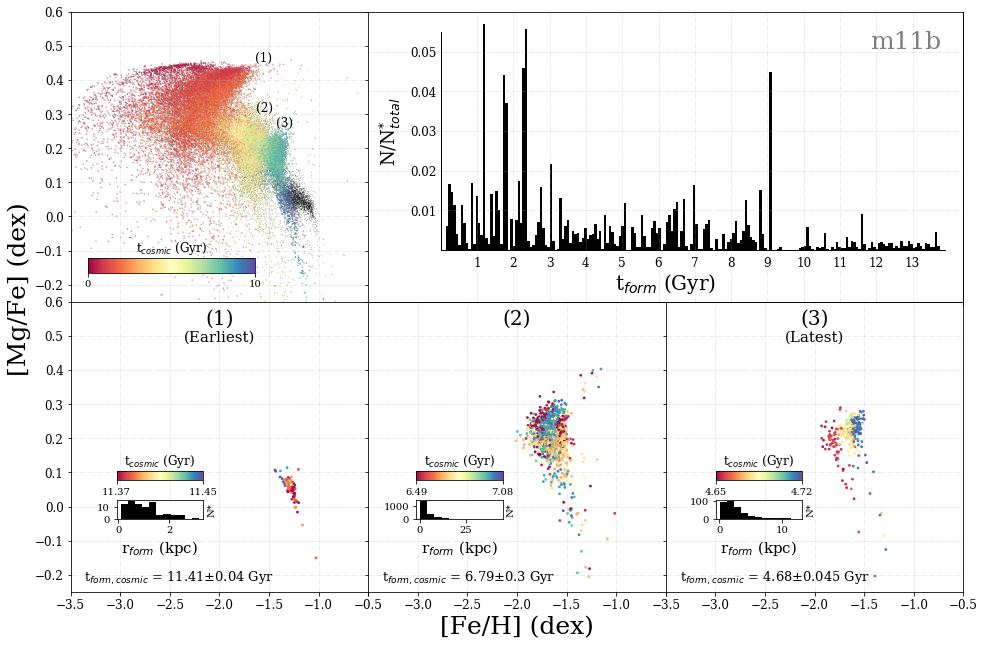

In [23]:
indices = []
indices2 = []
rfinds = []
rfinds2 = []
width = 0.1
countsarr = []
xbinsarr = []
ybinsarr = []
imagearr = []
widths = [0.1,0.15,0.04,0.1,0.3,0.05,0.045,0.05,0.1]

cmap1 = 'Spectral'

# For regions with significant Rform

ln = [0.29,0.55,0.81]
lefts = [ln[0],ln[1]-.125,ln[2]-.125,ln[0]-.125,ln[1]-.125,ln[2]-.125,ln[0]-.125,ln[1]-.125,ln[2]-0.125]
        #   1       2           3         4          5          6          7            8         9
lefts = np.array(lefts)

bottoms = [.7,.7,.7,.32,.32,.32,.15,.15,.15]

irange = 8

for i in range(0,irange):
    bottoms[i] = bottoms[i] - .1 #Adjust bottoms

xarray = np.linspace(-5,0)

for i in range(0,irange):
    indices.append(np.where( (age >= ages[i]-widths[i]) & (age <= ages[i] + widths[i]) 
                            & (Rform < 100)))
    
    indices2.append(np.where( (age >= ages[i]-widths[i]) & (age <= ages[i] + widths[i]) 
                            & (Rform < 20)))
    
    # Temporary assignment
    
    countsarrt,xbinsarrt,ybinsarrt,imagearrt = plt.hist2d(feh[indices[i]], mgfe[indices[i]], bins = [100,100])
    plt.close()
    
    # Assigning to the indices
    countsarr.append(countsarrt)
    xbinsarr.append(xbinsarrt)
    ybinsarr.append(ybinsarrt)
    imagearr.append(imagearrt)
    
    rfinds.append(np.where( (age >= ages[i]-width) 
                           & (age <= ages[i] + width )
                           & (Rform >= 50) & (Rform < 100)))
    
    rfinds2.append(np.where( (age >= ages[i]-width) 
                            & (age <= ages[i] + width ) 
                            & (Rform < 90)))
    
fig, ( (ax1, ax2, ax3), (ax4, ax5, ax6) ) = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True,
                                                                         figsize = (16,10.67))

axes = [ax1,ax2,ax3,ax4,ax5,ax6]

####################################################### PLOT ONE #########################################################
##########################################################################################################################

############# THE FOLLOWING CODE IS FOR GENERATING AN INSET COLORBAR ############

ind = np.where((age >= 13.798-11) )#& (Rform < 100))
counts1,xbins1,ybins1,image1 = plt.hist2d(feh[ind], mgfe[ind], bins = [100,100])

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(feh[ind], mgfe[ind], 
                                                                    age[ind], 'mean', bins= [100,100])

#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im = axes[0].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'Spectral', aspect='auto', vmin=0, vmax=10)
axes[0].clear()

cbar_ax = fig.add_axes([ 0.14, 0.54, 0.145, 0.02]) #left, bottom, width, height  # vertically oriented colorbar

cb = fig.colorbar(im, cax=cbar_ax, ticks = [0,10],  orientation = 'horizontal')
#cb.ax.yaxis.set_ticks_position("right")
cb.ax.set_xticklabels(['0', '10'], fontweight = 15) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"t$_{cosmic}$ (Gyr)")
#cb.ax.yaxis.set_label_position("left")

############# THE ABOVE CODE IS FOR GENERATING AN INSET COLORBAR ############

axes[0].grid(ls = '-.', alpha = 0.3)
#ax1.scatter(feh,mgfe-0.0005, s = 0.5, alpha = 0.1, c = 'black')
axes[0].scatter(feh,mgfe, s = 0.02, color = 'black', alpha = 0.5)
axes[0].scatter(feh[ind],mgfe[ind], s = 0.05, c = 13.79897-age[ind], cmap = "Spectral")
#ax1.axvline(-2, ls = "--", color = 'black', lw = 0.8, alpha = 0.7)
#ax1.axhline(0.25, ls = "--", color = 'black', lw = 0.8, alpha = 0.7)

#axes[0].set_ylabel("[Mg/Fe]", size = 25)
#axes[0].set_xlabel("[Fe/H]", size = 25)
#axes[0].xaxis.set_label_position("top")
#axes[0].xaxis.tick_top()
axes[0].set_xlim(-3.5,-0.5)
axes[0].set_ylim(-0.25,0.6)
#axes[0].text(-2., 0.54,r'Global $\alpha$-abundance', ha = 'center', size = 20)
#axes[0].text(-2, 0.49,'([Fe/H] vs. [Mg/Fe])', ha = 'center', size = 15)

xticks = axes[0].xaxis.get_majorticklabels()
yticks = axes[0].yaxis.get_majorticklabels()
plt.setp(yticks[0], visible = False)
plt.setp(yticks, size = 12)

##########################################################################################################################
desired = [2,4,6]
ilist = desired
while(len(ilist) < 6):
    ilist.insert(0,0)

print(ilist)

for i in range(3,6):
   
    print("i: " + str(i))
    print("ilist[i]: " + str(ilist[i]))
    print("AGE: " + str(ages[i]))
    print("AGE - w: " + str(ages[i] - width))
    print("AGE + w: " + str(ages[i] + width))
    print("Tform : [" + str(round(ages[i] - width,2)) + "," + str(round(ages[i] + width,2)) + "]")
    print("--------------------------------")
    
    bottomt = 13.798974-np.min(age[indices[ilist[i]]]) # Not 'ages' because this is the full list of ages - 
    topt = 13.798974-np.max(age[indices[ilist[i]]]) # - we select here the oldest and youngest stars in the galaxy.
    
    if(i > 0):
        ############# THE FOLLOWING CODE IS FOR GENERATING AN INSET COLORBAR ############
        
        #mean age for bins of stars in mgfe vs feh space
        mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(feh[indices[ilist[i]]], mgfe[indices[ilist[i]]], 
                                                                            13.7989-age[indices[ilist[i]]],
                                                                            'mean', bins= [100,100])
        
        #masks below cuts out where there are fewer stars than a particular threshold
        m1 = np.ma.masked_where(countsarr[i] < 1,  mean_age1)
        im1 = axes[i].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                        extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = cmap1, aspect='auto', vmin=bottomt,
                            vmax=topt)
        axes[i].clear()
        
        cbar_ax1 = fig.add_axes([lefts[i], bottoms[i]+0.05, 0.075, 0.0125]) #left, bottom, width, height  # vertically oriented colorbar
        
        cb1 = fig.colorbar(im1, cax=cbar_ax1, ticks = [bottomt, topt], orientation = 'horizontal')
        #cb.ax.yaxis.set_ticks_position("right")
        cb1.ax.set_xticklabels([str(round(bottomt,2)),str(round(topt,2))],
                              size = 10) # Used to make custom labels on the tick marks themselves
        cb1.ax.set_title(r"t$_{cosmic}$ (Gyr)", size = 12)
        #cb.ax.yaxis.set_label_position("left")
        
        ############# THE ABOVE CODE IS FOR GENERATING AN INSET COLORBAR ############
        
        # Main hist2d of global track
        #axes[i].hist2d(feh[indices[i]], mgfe[indices[i]], bins = 200, range = [[-3.5,-0.5],[-0.25,.6]], cmap = 'Greys')
        
        axes[i].grid(ls = '-.', alpha = 0.3)
        
        axes[i].scatter(feh[indices[ilist[i]]], mgfe[indices[ilist[i]]], s = 3, c = 13.798-age[indices[ilist[i]]],
                        cmap = cmap1)
    
        # Labels for Tform and panel number
        axes[i].text(-3.36, -0.22, 
                     r"t$_{form,cosmic}$ = " + str(round(13.798974 - ages[ilist[i]],2)) + r'$\pm$' + str(widths[ilist[i]]) + ' Gyr', size = 13)
        axes[i].text(-2., 0.535,'(' + str(i-2) + ')', ha = 'center', size = 20)
    
        if(i == 5):
            axes[i].text(-2, 0.485,'(Latest)', ha = 'center', size = 15)
        if(i == 3):
            axes[i].text(-2, 0.485,'(Earliest)', ha = 'center', size = 15)

        if(i == 1 or i == 2):
            axes[i].clear()
        
        # INSET FOR RFORM
        cbar_ax = fig.add_axes([lefts[i], bottoms[i], 0.075, 0.025]) #left, bottom, width, height  # vertically oriented colorbar
        
        if((i != 2)):
            cbar_ax.hist(Rform[indices[ilist[i]]], color = 'black', bins = 11)
        else:
            cbar_ax.hist(Rform[indices[ilist[i]]], color = 'black', bins = 11)

        #if(i == 2):
        #    cbar_ax.hist(Rform[rfinds[ilist[i]]] - 0.5, color = 'orange', bins = 1)
        #    cbar_ax.hist(Rform[rfinds[ilist[i]]] - 0.5, color = 'red', alpha = 0.4, bins = 1) # second for color

        
        cbar_ax.set_xlabel(r"r$_{form}$ (kpc)", size = 15)
        cbar_ax.set_ylabel("N*")
        
        #cb.ax.yaxis.set_ticks_position("right")
        #cb.ax.set_title(r"R$_{form}$ (kpc)")
        cbar_ax.yaxis.set_label_position("right")
        
        #END INSET
        
        if(i < 3):
            xticksbot = axes[i].xaxis.get_majorticklabels()
            plt.setp(xticksbot, visible = False) 
        if(i > 2):
            xticksbot = axes[i].xaxis.get_majorticklabels()
            plt.setp(xticksbot, size = 12)
            if(i == 4):
                plt.setp(xticksbot[0], visible = False) 
                plt.setp(xticksbot[6], visible = False) 
            yticksbot = axes[i].yaxis.get_majorticklabels()
            plt.setp(yticksbot, size = 12)
        
        
        # Adjustments
        axes[i].set_xlim(-3.5,-0.5)
        axes[i].set_ylim(-0.25,0.6)

        
axes[2] = fig.add_subplot(2,3,(2,3))

axes[2].grid(ls = '-.', alpha = 0.3)
axes[2].hist(13.798974 - age, bins = 200, weights = weights, color = 'black')


axes[2].tick_params(axis = 'y', direction = 'in', pad = -68, labelsize = 12)
axes[2].tick_params(axis = 'x', direction = 'in', pad = -45, labelsize = 12)
axes[2].tick_params(axis = "both", which = "both", bottom = False, top = False, left = False, right = False)

axes[2].yaxis.set_ticks([0.01,0.02,0.03,0.04,0.05])
axes[2].xaxis.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12,13])

#axes[2].yaxis.tick_right()
axes[2].set_ylim(-0.013, 0.06)
axes[2].set_xlim(-2., 14.4)
axes[2].text(13.3/2 - 0.45, -0.01, r"t$_{form}$ (Gyr)", size = 20, ha = 'center')
axes[2].text(-1.4,0.03, r"N/N$^{*}_{total}$", size = 18, ha = 'center', va = 'center', rotation = 90)

axes[4].set_xlabel("[Fe/H] (dex)", size = 25)

axes[2].plot([0, 13.9], [0,0], c = 'black', linewidth = 1)
axes[2].plot([0,0], [0,0.055], c = 'black', linewidth = 1)

    
fig.text(0.85,0.84, "m11b", alpha = 0.5, size = 25, ha = 'center', va = 'center')
fig.text(0.285, 0.815, "(1)", size = 12)
fig.text(0.286, 0.75, "(2)", size = 12)
fig.text(0.303, 0.73, "(3)", size = 12)
#fig.text(0.33, 0.74, "(4)", size = 12)
#fig.text(0.35, 0.63, "(5)", size = 12)
        
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.07,0.52,"[Mg/Fe] (dex)", va = 'center', size = 25, rotation = 90)
#fig.text(0.51,0.064, "[Fe/H] (dex)", ha = 'center', size = 25)
plt.savefig('m11b_rr_6panel.png', bbox_inches = 'tight', dpi = 150)
plt.savefig('m11b_rr_6panel_lowres.png', bbox_inches = 'tight', dpi = 72)

plt.show()

In [ ]:
print(ilist[5])

idloi = ids[np.isin(ids,ids[indices[8]])]
idsoi = ids[indices[ilist[5]]]

print(len(idsoi))
print(len(idloi))

In [ ]:
def load():
    galaxy = 'm11b'
    
    print('LOADING GALAXY: ' + galaxy + " in " + dirs[galaxy])
    
    part = gizmo.io.Read.read_snapshots(['star', 'gas'], 'snapshot', 506, assign_host_principal_axes=True, simulation_directory=dirs[galaxy],
                                       assign_formation_coordinates = False)
    return part, galaxy

part, galaxy = load()

species='star'
mass = part[species].prop('mass')
age = part[species].prop('age')
feh  = part[species].prop('metallicity.fe')
sife = part[species].prop('metallicity.si - metallicity.fe')
cafe = part[species].prop('metallicity.ca - metallicity.fe') 
ofe = part[species].prop('metallicity.o - metallicity.fe') 
ids = part[species].prop('id')
idg = part['gas'].prop('id')
vel = part[species].prop('velocity')

#Rxy = part[species].prop('host.distance.principal.cylindrical')[:,0]
#z = part[species].prop('host.distance.principal.cylindrical')[:,1]
mgfe = part[species].prop('metallicity.mg - metallicity.fe')

x = part[species].prop('host.distance.principal')[:,0]
y = part[species].prop('host.distance.principal')[:,1]
z = part[species].prop('host.distance.principal')[:,2]

xg = part['gas'].prop('host.distance.principal')[:,0]
yg = part['gas'].prop('host.distance.principal')[:,1]
zg = part['gas'].prop('host.distance.principal')[:,2]

R = part[species].prop('host.distance.principal.spherical')[:,0]
phi = part[species].prop('host.distance.principal.cylindrical')[:,2]*(180.0/np.pi)

32290
489
489
0.12043749522677949


(-5, 5)

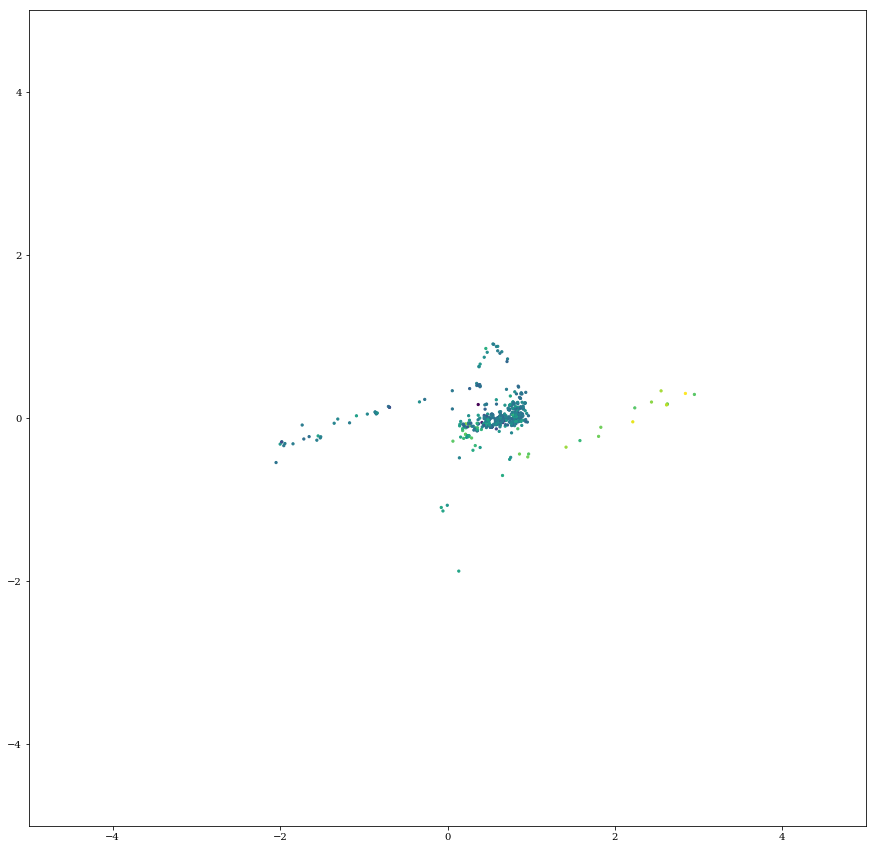

In [56]:
plt.figure(figsize = (15,15))
print(len(vel[:,1]))
print(len(xg[idloi]))
print(len(vel[:,0][np.isin(ids,idsoi)]))

M = np.hypot(vel[:,0][np.isin(ids,idsoi)], vel[:,1][np.isin(ids,idsoi)])

plt.scatter(xg[idloi], yg[idloi], c= 'red', s = 5)
plt.scatter(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], c = mgfe[np.isin(ids,idsoi)], s = 5)

print(np.max(age[np.isin(ids,idsoi)]))
#plt.quiver(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], vel[:,0][np.isin(ids,idsoi)], 
#           vel[:,1][np.isin(ids,idsoi)], 1.44-age[np.isin(ids,idsoi)], pivot = 'tail', scale = 10, units = 'dots')

#newind = np.where( (age > 0.15) & (age < 0.2))

#plt.quiver(x[newind], y[newind], vel[:,0][newind], 
#           vel[:,1][newind], 1.4454-age[newind], pivot = 'tail', scale = 10, units = 'dots', cmap = cmap1)

plt.xlim(-5,5)
plt.ylim(-5,5)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


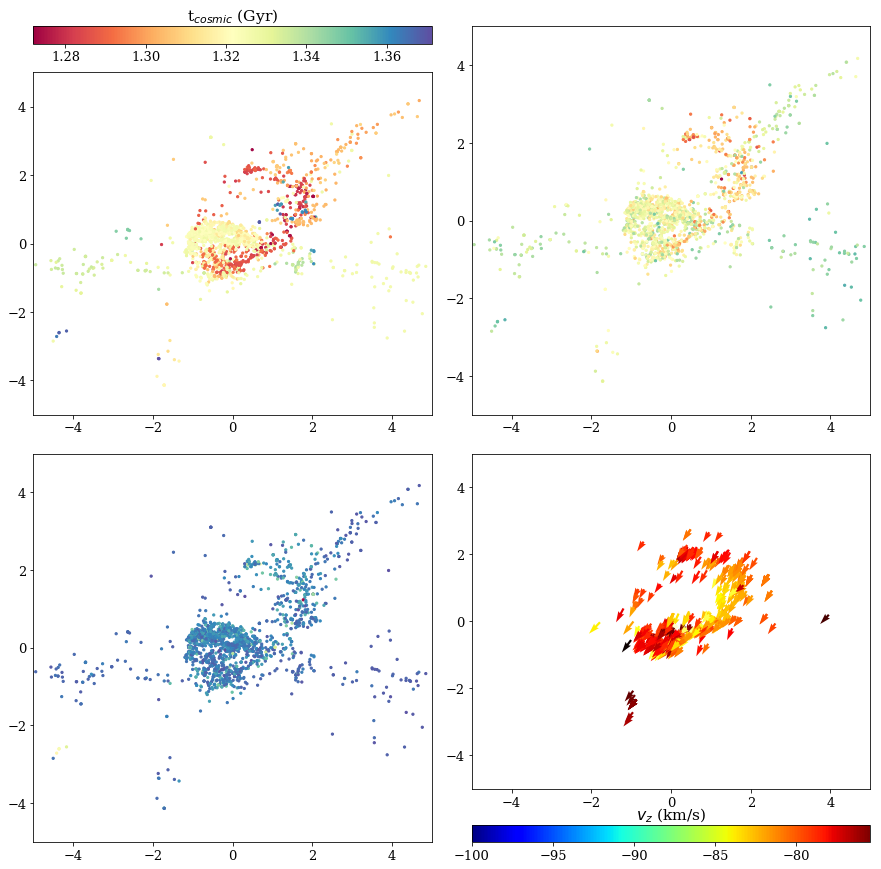

In [237]:
fig = plt.figure(figsize=(15, 15))
from mpl_toolkits.axes_grid1 import make_axes_locatable

indone = np.isin(ids,idsoi)
#indone = np.where( (age > 0.135) & (age < 0.165))

###########################################################################################################################
ax1 = fig.add_subplot(221)

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(x[indone], y[indone], 
                                                                    1.4454-age[indone], 'mean', bins= [100,100])


#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im1 = ax1.imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'Spectral', aspect='auto'
                 , vmin=np.min(1.4454-age[indone])
                 , vmax=np.max(1.4454-age[indone]))

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.4)

ax1.clear()

cb = fig.colorbar(im1, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_title(r"t$_{cosmic}$ (Gyr)")

ax1.scatter(x[indone], y[indone], c = 1.4454-age[indone], s = 5, cmap = 'Spectral')
ax1.set_ylim(-5,5)
ax1.set_xlim(-5,5)
###########################################################################################################################
ax2 = fig.add_subplot(222)

ax2.scatter(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], c = feh[np.isin(ids,idsoi)], s = 5, cmap = 'Spectral')
ax2.set_ylim(-5,5)
ax2.set_xlim(-5,5)

###########################################################################################################################
ax3 = fig.add_subplot(223)
ax3.scatter(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], c = mgfe[np.isin(ids,idsoi)], s = 5, cmap = 'Spectral')
ax3.set_ylim(-5,5)
ax3.set_xlim(-5,5)

###########################################################################################################################
ax4 = fig.add_subplot(224)

newind = np.where( (age > 0.15) & (age < 0.2))

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(vel[:,0][newind], vel[:,1][newind], 
                                                                    vel[:,2][newind], 'mean', bins= [100,100])

#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im2 = ax4.imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'jet', aspect='auto', 
                 vmin=-100, 
                 vmax=np.max(vel[:,2][newind]))

divider = make_axes_locatable(ax4)
cax2 = divider.append_axes('bottom', size='5%', pad=0.5)

ax4.clear()

cb = fig.colorbar(im2, cax=cax2, orientation='horizontal')
cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_title(r"$v_z$ (km/s)")

#ax4.scatter(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], c = 'black', s = 1)

ax4.quiver(x[newind], y[newind], vel[:,0][newind], 
           vel[:,1][newind], vel[:,2][newind], pivot = 'tail', scale = 15, headwidth = 3, units = 'dots', cmap = "hot")

ax4.set_ylim(-5,5)
ax4.set_xlim(-5,5)

plt.subplots_adjust(wspace=.1, hspace=.1)

plt.savefig("snap83_2x2.png", dpi = 150, bbox_inches = 'tight')

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


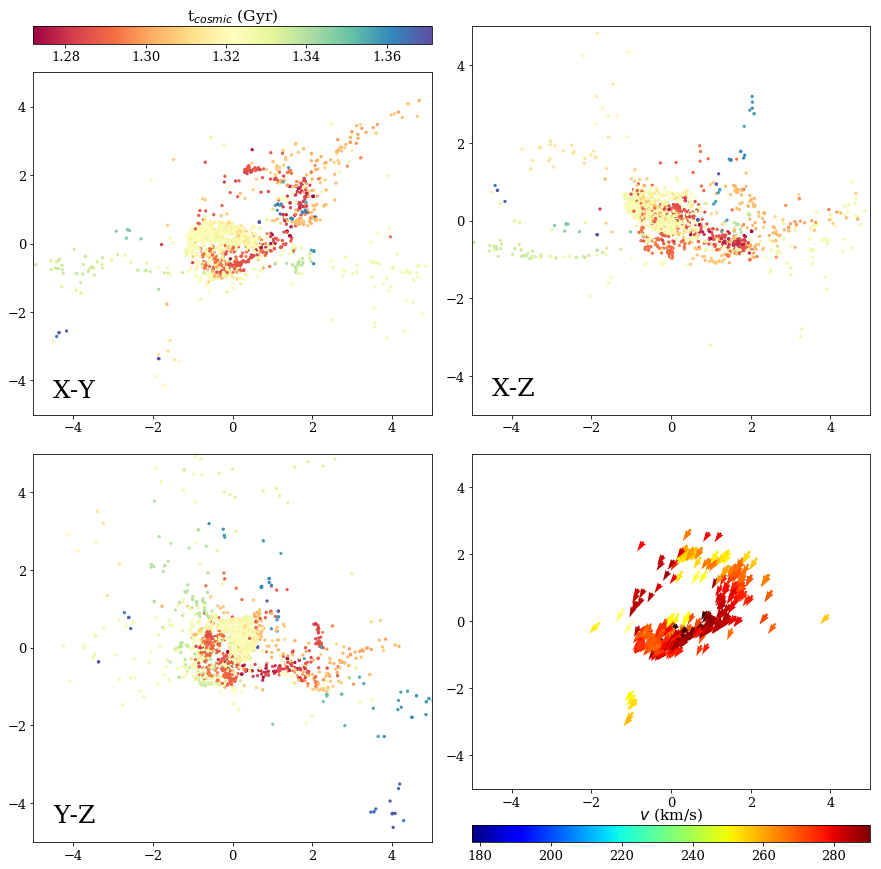

In [257]:
fig = plt.figure(figsize=(15, 15))
from mpl_toolkits.axes_grid1 import make_axes_locatable

indone = np.isin(ids,idsoi)
#indone = np.where( (age > 0.135) & (age < 0.165))

###########################################################################################################################
ax1 = fig.add_subplot(221)

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(x[indone], y[indone], 
                                                                    1.4454-age[indone], 'mean', bins= [100,100])


#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im1 = ax1.imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'Spectral', aspect='auto'
                 , vmin=np.min(1.4454-age[indone])
                 , vmax=np.max(1.4454-age[indone]))

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.4)

ax1.clear()

cb = fig.colorbar(im1, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_title(r"t$_{cosmic}$ (Gyr)")

ax1.scatter(x[indone], y[indone], c = 1.4454-age[indone], s = 5, cmap = 'Spectral')
ax1.set_ylim(-5,5)
ax1.set_xlim(-5,5)
ax1.text(-4.5,-4.5,"X-Y", size = 25)
###########################################################################################################################
ax2 = fig.add_subplot(222)

ax2.scatter(x[indone], z[indone], c = 1.4454-age[indone], s = 5, cmap = 'Spectral')
ax2.set_ylim(-5,5)
ax2.set_xlim(-5,5)
ax2.text(-4.5,-4.5,"X-Z", size = 25)
###########################################################################################################################
ax3 = fig.add_subplot(223)
ax3.scatter(y[indone], z[indone], c = 1.4454-age[indone], s = 5, cmap = 'Spectral')
ax3.set_ylim(-5,5)
ax3.set_xlim(-5,5)
ax3.text(-4.5,-4.5,"Y-Z", size = 25)
###########################################################################################################################
ax4 = fig.add_subplot(224)

newind = np.where( (age > 0.15) & (age < 0.2))

#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(vel[:,0][newind], vel[:,1][newind], 
                                                                    np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2), 'mean', bins= [100,100])

#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im2 = ax4.imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'jet', aspect='auto', 
                 vmin=np.min(np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2)), 
                 vmax=np.max(np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2)))

divider = make_axes_locatable(ax4)
cax2 = divider.append_axes('bottom', size='5%', pad=0.5)

ax4.clear()

cb = fig.colorbar(im2, cax=cax2, orientation='horizontal')
cb.ax.xaxis.set_ticks_position("bottom")
cb.ax.set_title(r"$v$ (km/s)")

#ax4.scatter(x[np.isin(ids,idsoi)], y[np.isin(ids,idsoi)], c = 'black', s = 1)

ax4.quiver(x[newind], y[newind], vel[:,0][newind], 
           vel[:,1][newind], np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2), pivot = 'tail', scale = 15, headwidth = 3, units = 'dots', cmap = "hot")

ax4.set_ylim(-5,5)
ax4.set_xlim(-5,5)

plt.subplots_adjust(wspace=.1, hspace=.1)

plt.savefig("All_v.png", dpi = 150, bbox_inches = 'tight')

plt.show()

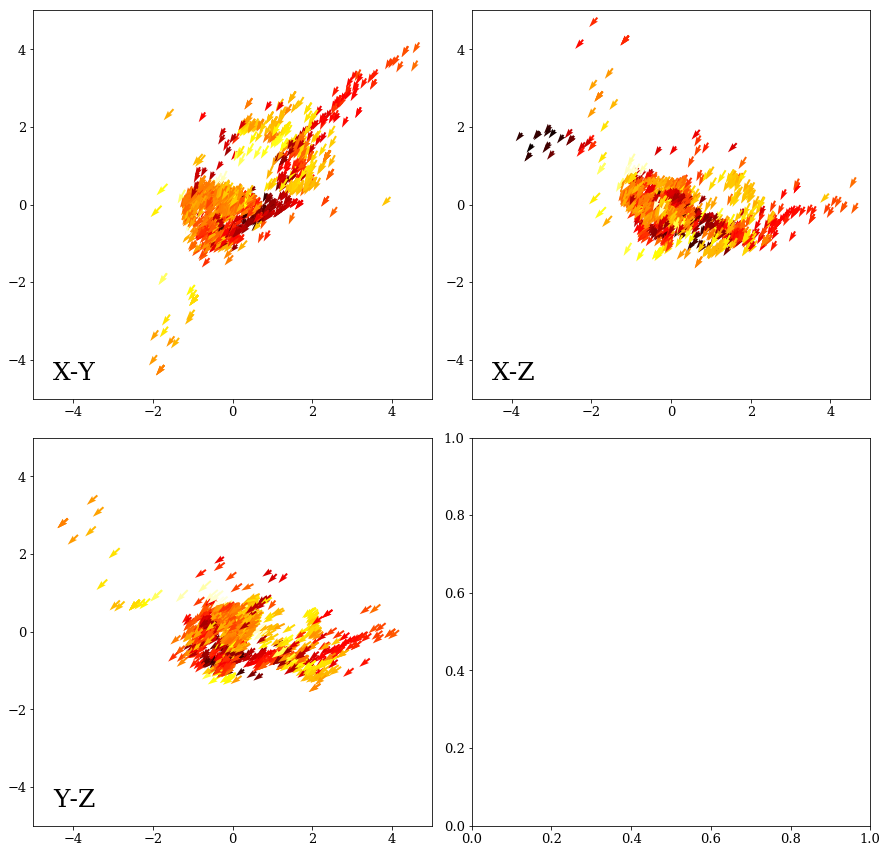

In [264]:
fig = plt.figure(figsize=(15, 15))
from mpl_toolkits.axes_grid1 import make_axes_locatable

indone = np.isin(ids,idsoi)
#indone = np.where( (age > 0.135) & (age < 0.165))

###########################################################################################################################
ax1 = fig.add_subplot(221)
newind = np.where( (age > 0.12) & (age < 0.2))

ax1.quiver(x[newind], y[newind], vel[:,0][newind], 
           vel[:,1][newind], np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2), pivot = 'tail', scale = 15, headwidth = 3, units = 'dots', cmap = "hot")

ax1.set_ylim(-5,5)
ax1.set_xlim(-5,5)
ax1.text(-4.5,-4.5,"X-Y", size = 25)
###########################################################################################################################
ax2 = fig.add_subplot(222)


ax2.quiver(x[newind], z[newind], vel[:,0][newind], 
           vel[:,1][newind], np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2), pivot = 'tail', scale = 15, headwidth = 3, units = 'dots', cmap = "hot")

ax2.set_ylim(-5,5)
ax2.set_xlim(-5,5)
ax2.text(-4.5,-4.5,"X-Z", size = 25)
###########################################################################################################################
ax3 = fig.add_subplot(223)

ax3.quiver(y[newind], z[newind], vel[:,1][newind], 
           vel[:,2][newind], np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2), pivot = 'tail', scale = 15, headwidth = 3, units = 'dots', cmap = "hot")

ax3.set_ylim(-5,5)
ax3.set_xlim(-5,5)
ax3.text(-4.5,-4.5,"Y-Z", size = 25)
###########################################################################################################################
ax4 = fig.add_subplot(224)

#newind = np.where( (age > 0.15) & (age < 0.2))
#
#ax4.quiver(x[newind], y[newind], vel[:,0][newind], 
#           vel[:,1][newind], np.sqrt(vel[:,0][newind]**2 + vel[:,1][newind]**2 + vel[:,2][newind]**2), pivot = 'tail', scale = 15, headwidth = 3, units = 'dots', cmap = "hot")
#
#ax4.set_ylim(-5,5)
#ax4.set_xlim(-5,5)

plt.subplots_adjust(wspace=.1, hspace=.1)

plt.savefig("All_v.png", dpi = 150, bbox_inches = 'tight')

plt.show()

In [15]:
import pickle
m11b_ids_panel7 = ids[indices[6]]

file_a = 'galaxies/m11b/m11b_ids_panel7'
outfile_a = open(file_a,'wb')
pickle.dump(m11b_ids_panel7,outfile_a)
outfile_a.close()

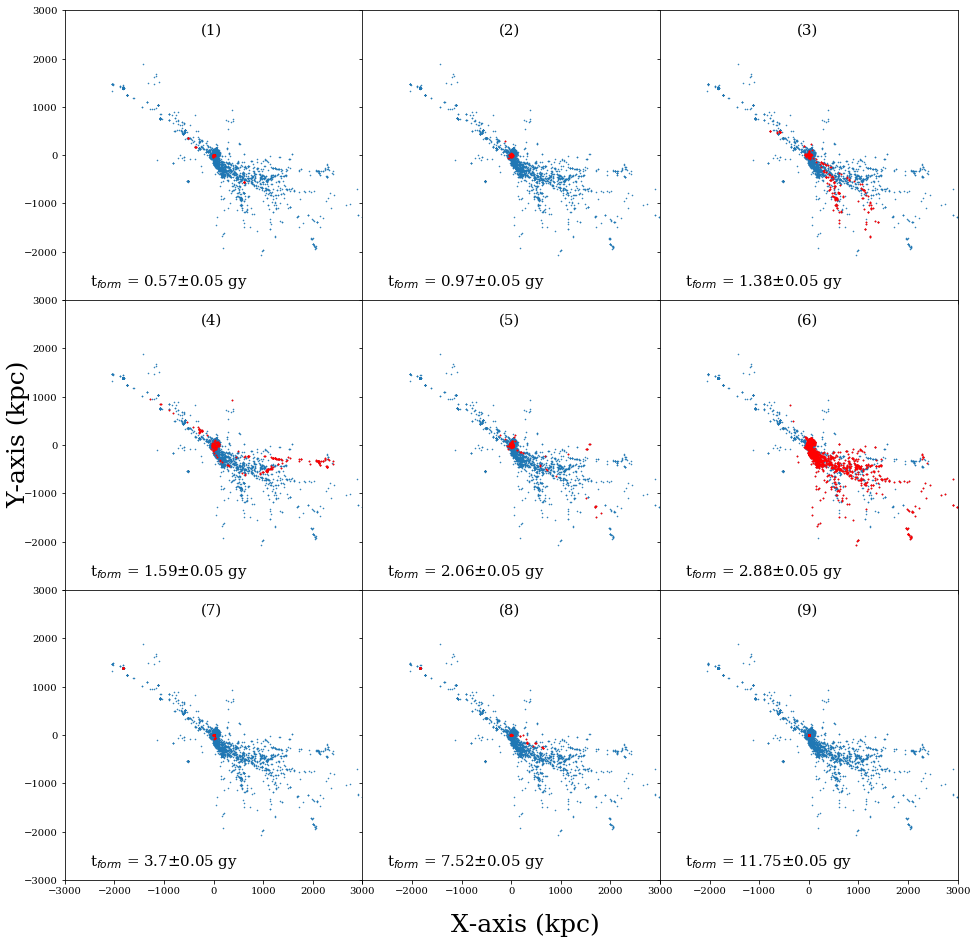

In [143]:
rel_ages = ages

fig, ( (ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) ) = plt.subplots(nrows = 3, ncols = 3, sharex = True, sharey = True,
                                                                         figsize = (16,16))

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for i in range(0,9):
    axes[i].set_xlim([-3000,3000])
    axes[i].set_ylim([-3000,3000])
    axes[i].scatter(y,x, s = 0.3)
    axes[i].scatter(y[indices[i]], x[indices[i]], color = 'r', s = 0.7)
    axes[i].text(-2500, -2700, r"t$_{form}$ = " + str(round(13.798 - ages[i],2)) + r'$\pm$' + str(width) + ' gy', size = 15)
    axes[i].text(-250, 2500,'(' + str(i+1) + ')', size = 15)
    if(i >= 6): # Adjusts the bottom axis to not have overlapping ticks
        xticks = axes[i].xaxis.get_majorticklabels()
        plt.setp(xticks[0], visible=False)
    yticks2 = axes[i].yaxis.get_majorticklabels()
    plt.setp(yticks2[:1:1], visible=False)
    if(i == 6):
        plt.setp(yticks2[0], visible=True)
        plt.setp(xticks[0], visible=True)

plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.075,0.56,"Y-axis (kpc)", size = 25, rotation = 90)
fig.text(0.46,0.08, "X-axis (kpc)", size = 25)
plt.savefig('m11bv2-x_vs_y.png', bbox_inches = 'tight')
plt.show()


489


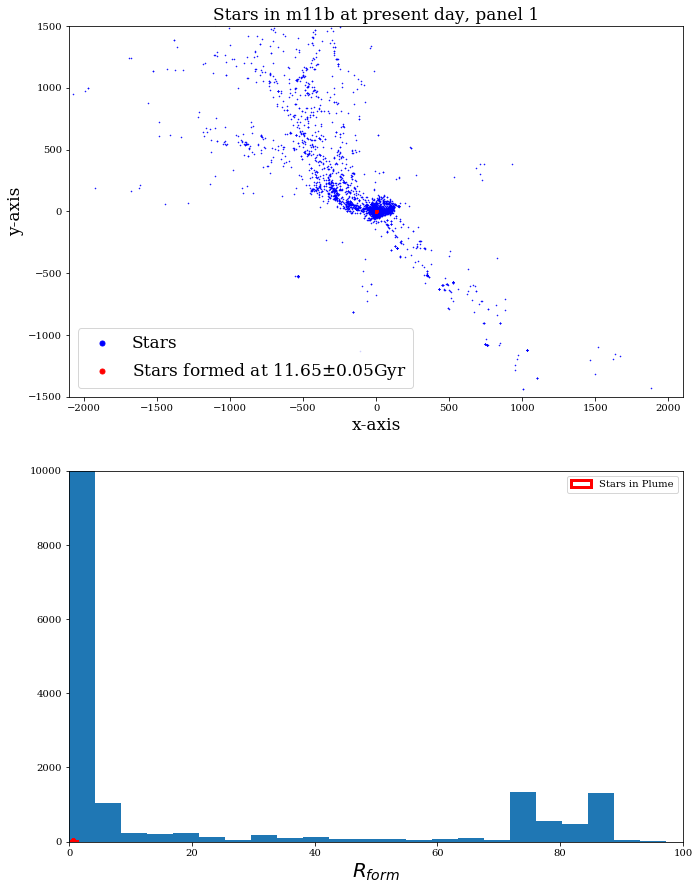

In [118]:
fig = plt.figure(figsize = (11,15))

panelno = 1
p = panelno - 1

ax1 = fig.add_subplot(211)

index1 = np.where( (age >= ages[p]- width + width * (4/3)) & (age <= ages[p] + width )) # OLDER
index2 = np.where( (age >= ages[p]- width) & (age <= ages[p] + width - width*(4/3) )) # YOUNGER

ax1.scatter(x,y, s = 0.3, c = 'blue')
ax1.scatter(x[indices[p]], y[indices[p]], color = 'r', s = 3.7)

ax1.scatter(-3000, -3000, c = 'blue', label='Stars', s = 25)

ax1.scatter(-3000, -3000, label=r'Stars formed at ' + str(round(13.7 - ages[p],2)) + r'$\pm$' + str(width) + "Gyr", color = 'r', s = 25)

ax1.legend(fontsize = 17)
ax1.set_xlabel("x-axis", fontsize = 17)
ax1.set_ylabel("y-axis", fontsize = 17)
ax1.set_title("Stars in m11b at present day, panel " + str(p+1), size = 17)

ax1.set_ylim(-1500,1500)
ax1.set_xlim(-2100,2100)

ax2 = fig.add_subplot(212)

print(np.size(Rform[index2]))

ax2.hist(Rform, bins = 350)
ax2.hist(Rform[indices[p]], color = 'red', histtype = 'step', lw = 3, bins = 20, label = "Stars in Plume")
#ax2.hist(Rform[index1], color = 'pink', histtype = 'step', lw = 3, bins = 7, label = "Older third")
#ax2.hist(Rform[index2], color = 'purple', histtype = 'step', lw = 3, bins = 10, label = "Younger Third")

ax2.set_xlim(0,100)
ax2.set_ylim(0,10000)
ax2.legend()
ax2.set_xlabel(r"$R_{form}$", size = 20)

plt.savefig('v2_Panel_new_' + str(panelno) + '.png', bbox_inches = 'tight')
plt.show()

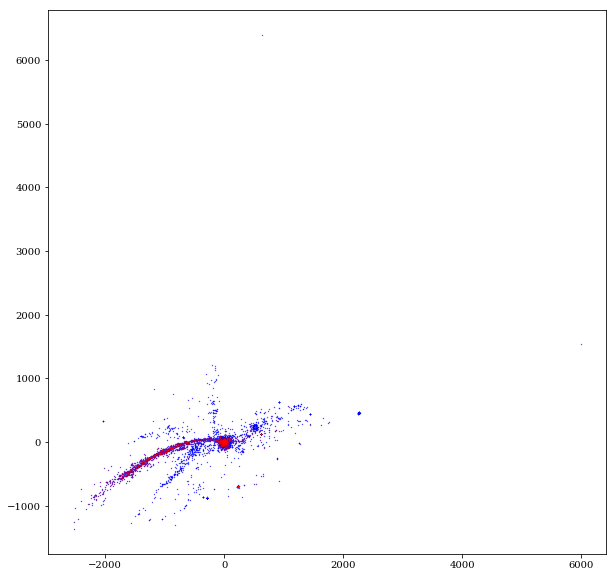

In [30]:


plt.figure(figsize = (10,10))
plt.scatter(x,y, s = 0.1, color = 'blue')
plt.scatter(x[ids_panel9], y[ids_panel9], color = 'red', s = 0.01)

plt.show()

In [22]:
plt.figure(figsize = (11,7.5))
plt.hist(Rform[indices[8]], bins = 50)
plt.xlabel(r"$R_{form}$", size = 20)

IndexError: list index out of range

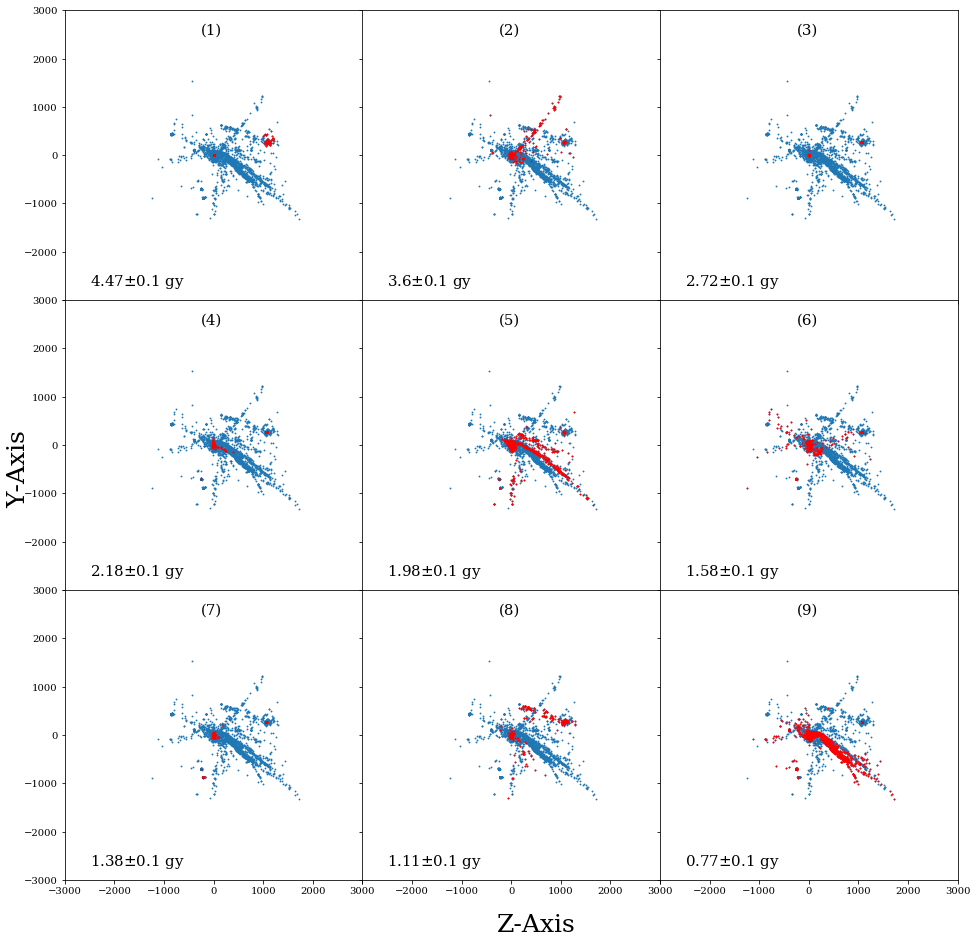

In [70]:

fig, ( (ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) ) = plt.subplots(nrows = 3, ncols = 3, sharex = True, sharey = True,
                                                                         figsize = (16,16))

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for i in range(0,9):
    axes[i].scatter(z,y, s = 0.7)
    axes[i].set_xlim([-3000,3000])
    axes[i].set_ylim([-3000,3000])
    axes[i].scatter(z[indices[i]], y[indices[i]], color = 'r', s = 0.7)
    axes[i].text(-2500, -2700, str(round(13.7 - ages[i],2)) + r'$\pm$' + str(width) + ' gy', size = 15)
    axes[i].text(-250, 2500,'(' + str(i+1) + ')', size = 15)
    if(i >= 6): # Adjusts the bottom axis to not have overlapping ticks
        xticks = axes[i].xaxis.get_majorticklabels()
        plt.setp(xticks[0], visible=False)
    yticks2 = axes[i].yaxis.get_majorticklabels()
    plt.setp(yticks2[:1:1], visible=False)
    if(i == 6):
        plt.setp(yticks2[0], visible=True)
        plt.setp(xticks[0], visible=True)

plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.075,0.5,"Y-Axis", size = 25, rotation = 90)
fig.text(0.5,0.08, "Z-Axis", size = 25)
plt.savefig('m11b-z_vs_y.png', bbox_inches = 'tight')
plt.show()


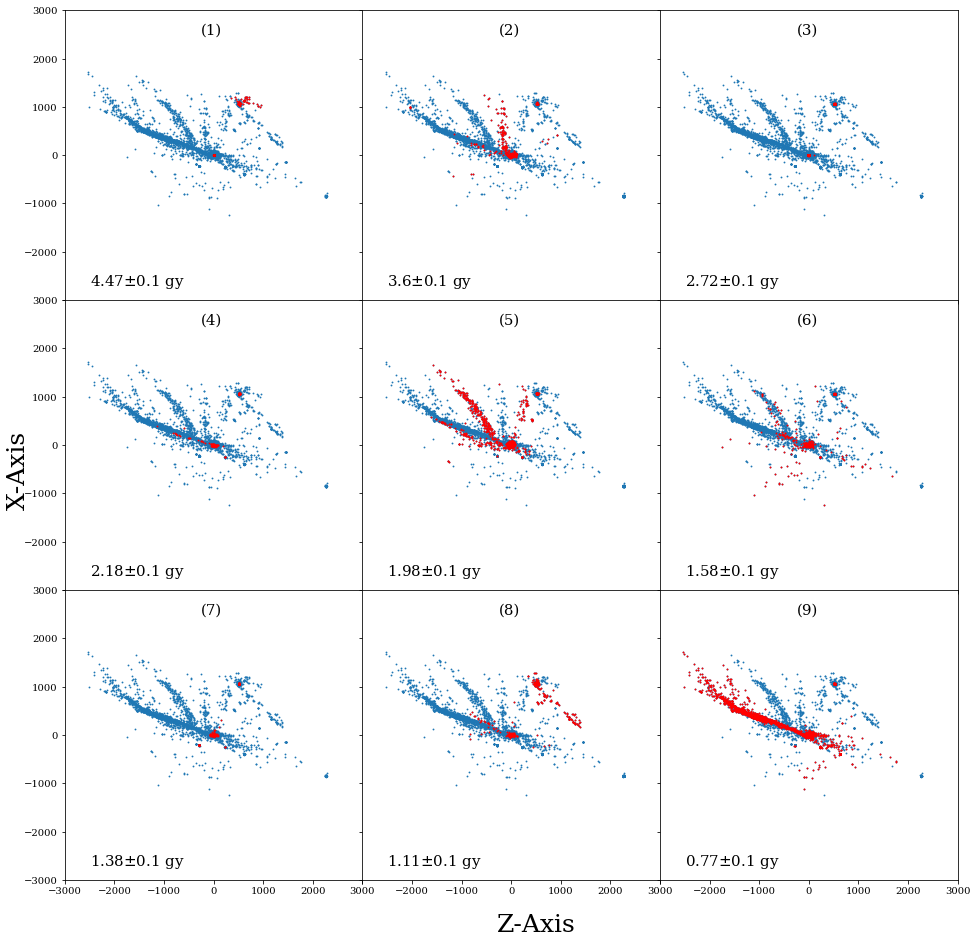

In [71]:
fig, ( (ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) ) = plt.subplots(nrows = 3, ncols = 3, sharex = True, sharey = True,
                                                                         figsize = (16,16))

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for i in range(0,9):
    axes[i].scatter(x,z, s = 0.7)
    axes[i].set_xlim([-3000,3000])
    axes[i].set_ylim([-3000,3000])
    axes[i].scatter(x[indices[i]], z[indices[i]], color = 'r', s = 0.7)
    axes[i].text(-2500, -2700, str(round(13.7 - ages[i],2)) + r'$\pm$' + str(width) + ' gy', size = 15)
    axes[i].text(-250, 2500,'(' + str(i+1) + ')', size = 15)
    if(i >= 6): # Adjusts the bottom axis to not have overlapping ticks
        xticks = axes[i].xaxis.get_majorticklabels()
        plt.setp(xticks[0], visible=False)
    yticks2 = axes[i].yaxis.get_majorticklabels()
    plt.setp(yticks2[:1:1], visible=False)
    if(i == 6):
        plt.setp(yticks2[0], visible=True)
        plt.setp(xticks[0], visible=True)

    

plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.075,0.5,"X-Axis", size = 25, rotation = 90)
fig.text(0.5,0.08, "Z-Axis", size = 25)
plt.savefig('m11b-x_vs_z.png', bbox_inches = 'tight')
plt.show()


In [13]:
## RELEVANT SNAPSHOTS ##
relevant_snaps = [401, 435, 471, 493, 501, 518, 526, 538, 552]

rel_ages = [9.228296050274071, 10.102812113376736, 10.9773281764794, 11.515491907619502, 11.71730330679704, 12.120926105152117, 12.322737504329654, 12.591819369899705, 12.928171701862269]

correspondings = [412, 446, 486, 534, 539, 544, 550, 555, 561]

corr_ages = [9.50745483, 10.36813558, 11.35579099, 12.50060028, 12.61717457, 12.73323330, 12.87181870, 12.98673819, 13.12395328 ]

rs = [11.35579099, 12.50060028, 12.61717457, 12.73323330, 12.87181870, 12.98673819]

stor = []
for i in range(0, len(relevant_snaps) - 1):
    if(i > 1):
        if( ((correspondings[i]-relevant_snaps[i]) < (correspondings[i]-relevant_snaps[i-1])) ):
            stor.append(correspondings[i])
        else:
            stor.append(correspondings[i+1])

print(stor)

rs = np.array(relevant_snaps)
cp = np.array(correspondings)

np.average(cp-rs)

keepers = [486, 534, 539, 544, 550, 555]

[486, 534, 539, 544, 550, 555]


In [62]:
import imageio
images = []

for i in range(485,510):
    images.append(imageio.imread("C:/Users/patel/Desktop/Xy/m11b/xy_Snap" + str(i) + '.png'))
    print((i+1-485)/25)
imageio.mimsave('rot_zoom_showoff_m11b.gif', images, duration = 1/3)

0.04
0.08
0.12
0.16
0.2
0.24
0.28
0.32
0.36
0.4
0.44
0.48
0.52
0.56
0.6
0.64
0.68
0.72
0.76
0.8
0.84
0.88
0.92
0.96
1.0


In [ ]:
    mass = part[species].prop('mass')

    feh  = part[species].prop('metallicity.fe')
    sife = part[species].prop('metallicity.si - metallicity.fe')
    cafe = part[species].prop('metallicity.ca - metallicity.fe') 
    ofe = part[species].prop('metallicity.o - metallicity.fe') 
    mgfe = part[species].prop('metallicity.mg - metallicity.fe')
    age = part['star'].prop('age')
    x = part[species].prop('host.distance.principal')[:,0]
    y = part[species].prop('host.distance.principal')[:,1]
    z = part[species].prop('host.distance.principal')[:,2]

    xg = part['gas'].prop('host.distance.principal')[:,0]
    yg = part['gas'].prop('host.distance.principal')[:,1]
    zg = part['gas'].prop('host.distance.principal')[:,2]

    ids = part['star'].prop('id')
    idg = part['gas'].prop('id')    
    R = part[species].prop('host.distance.principal.spherical')[:,0]
    phi = part[species].prop('host.distance.principal.cylindrical')[:,2]*(180.0/np.pi)
    Rform = []
    if(formcords == True):
        Rform = part['star'].prop('form.host.distance.principal.spherical')[:,0]